## Classifying handwritten digits with a CNN


In the previous exercies, we worked with fully-connected neural networks, which are good at handling tabular data, where the inputs and targets are easily presented as vectors.

However, in the case of images, or image-like objects, such models are less efficient for reasons we have discussed in the slides. When inputs are images, or image-like data, a more natural choice of model is a convolution neural network—in particularly, a model which uses 2D convolutional layers.

Before we start worrying about choosing models, let's first acquaint ourselves with the MNIST data.

The first step is to select a directory for the data to live.

In [1]:
import numpy as np

mnist_root = "mnist-data/"

If we all set a path this way it will help to maintain consistency throughout this exercise.

### Task 1: Access the MNIST dataset.

PyTorch has a (sort of) sister Python library for dealing with images: [``Torchvision``](https://pytorch.org/vision/stable/index.html) (take a look at the website for a few minutes).

In the previous exercies, we used a custom ``Dataset`` object created specifically for this event, but with ``Torchvision`` come several easy-to-use datasets, one of which is the MNIST digits.

- Look at the arguments of the MNIST datset: what options do we have?
- Instantiate the (training) dataset.
- Iterate over it: how are the inputs and targets presented to us?
- Plot some images, and set their targets as the title, to make sure the data make sense.

Note: this section might be challenging for many people, so we will go through it together first.

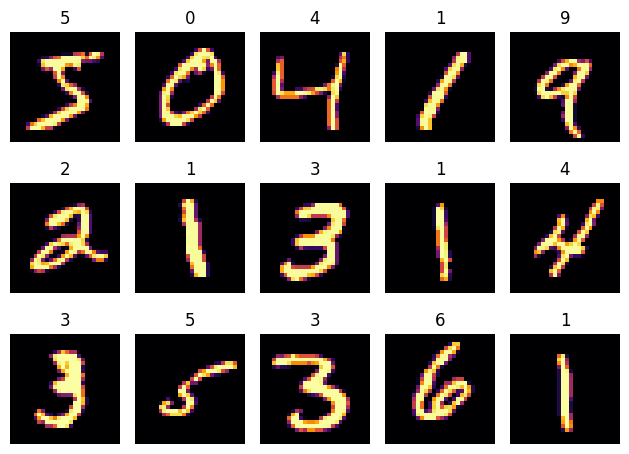

In [35]:
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
data_set = MNIST(root=mnist_root, download=True)

# Each element in data set is an image, with an associated integer, telling us 
# what number it is
# Let's plot this

fig, axes = plt.subplots(3, 5)
for i, ax in enumerate(axes.ravel()):
    ax.imshow(data_set.data[i], cmap="inferno")
    ax.set_title(f"{data_set.targets[i]}")
    ax.set_axis_off()
plt.tight_layout()
plt.show()

### Task 2

As before, we have a dataset which gives us inputs and targets, but we still need to convert the data to ``torch.Tensors``

#### Part (a) — raw data to ``Tensors``

Let's do this basic steps first: supply transforms to map between the raw data and ``torch.Tensors``.



#### Part (b) — fun with data augmentation

Additionally, with image data there are some other consideration we might make:
- Are CNNs rotationally invariant?
  - If we want our model to work on images which are not of a regular orientation, we must use random rotations as a form of augmentation.
- If we train a model on purely black-and-white images, how will it fare on more colourful data?
- Go to ``Torchvision``'s [transforms](https://pytorch.org/vision/stable/transforms.html) and look at the available forms of images augmentation.
  - Take a few minutes to pick ones you think might be relevant.
  - Let's discuss and choose some:
    - ...
    - ...
    - ...

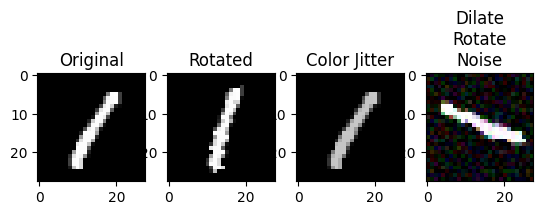

In [277]:
# Rotating images and gray scale
from torchvision.transforms import RandomRotation, ColorJitter, ToTensor, Compose
import scipy
rotater = RandomRotation(degrees=(0, 180))
jitter = ColorJitter(brightness=.5, hue=.3)
jitter2 = ColorJitter(brightness=0.1, hue=0.1, saturation=0.1, contrast=0.1)

def add_noise(x, noise_level=0.4, x_min=0, x_max=1):
    x_noise = x + noise_level*(np.random.random(x.shape) - 0.5)
    return np.clip(x_noise, x_min, x_max)

def dilate_erode(x, max_kernel_size=3):
    # Dilate or erode image based on a random number
    kernel_size = np.random.randint(-max_kernel_size,  max_kernel_size+1)
    if kernel_size >= 0:
        return scipy.ndimage.grey_dilation(x, size=kernel_size)
    else:
        return scipy.ndimage.grey_erosion(x, size=np.abs(kernel_size))

# Combine multiple transforms
transform_seq = []
transform_seq.append(lambda x: dilate_erode(x))      # dilate while numpy array
transform_seq.append(ToTensor())   # first, convert to tensor
transform_seq.append(lambda x: x.repeat(3, 1, 1))       # second, convert to RGB image
transform_seq.append(rotater)       # Then rotate randomly
# transform_seq.append(jitter2)       # Then jitter the colors
transform_seq.append(lambda x: add_noise(x, noise_level=0.4))       # Then jitter the colors
transform_seq.append(jitter2)       # Then jitter the colors
transform_seq = Compose(transform_seq)

fig, ax = plt.subplots(1, 4)
im_ind = 3
ax[0].imshow(data_set.data[im_ind], cmap='grey', vmin=0, vmax=data_set.data[im_ind].max())
ax[1].imshow(rotater(data_set.data[im_ind:im_ind+1])[0], vmin=0, vmax=data_set.data[im_ind].max(), cmap='grey')
ax[2].imshow(jitter(data_set.data[im_ind:im_ind+1])[0], vmin=0, 
             vmax=data_set.data[im_ind].max(), cmap='grey')
ax[3].imshow(np.moveaxis(np.asarray(transform_seq(np.asarray(data_set.data[im_ind]))), 0, -1))
ax[0].set_title('Original')
ax[1].set_title('Rotated')
ax[2].set_title('Color Jitter')
ax[3].set_title('Dilate\nRotate\nNoise');

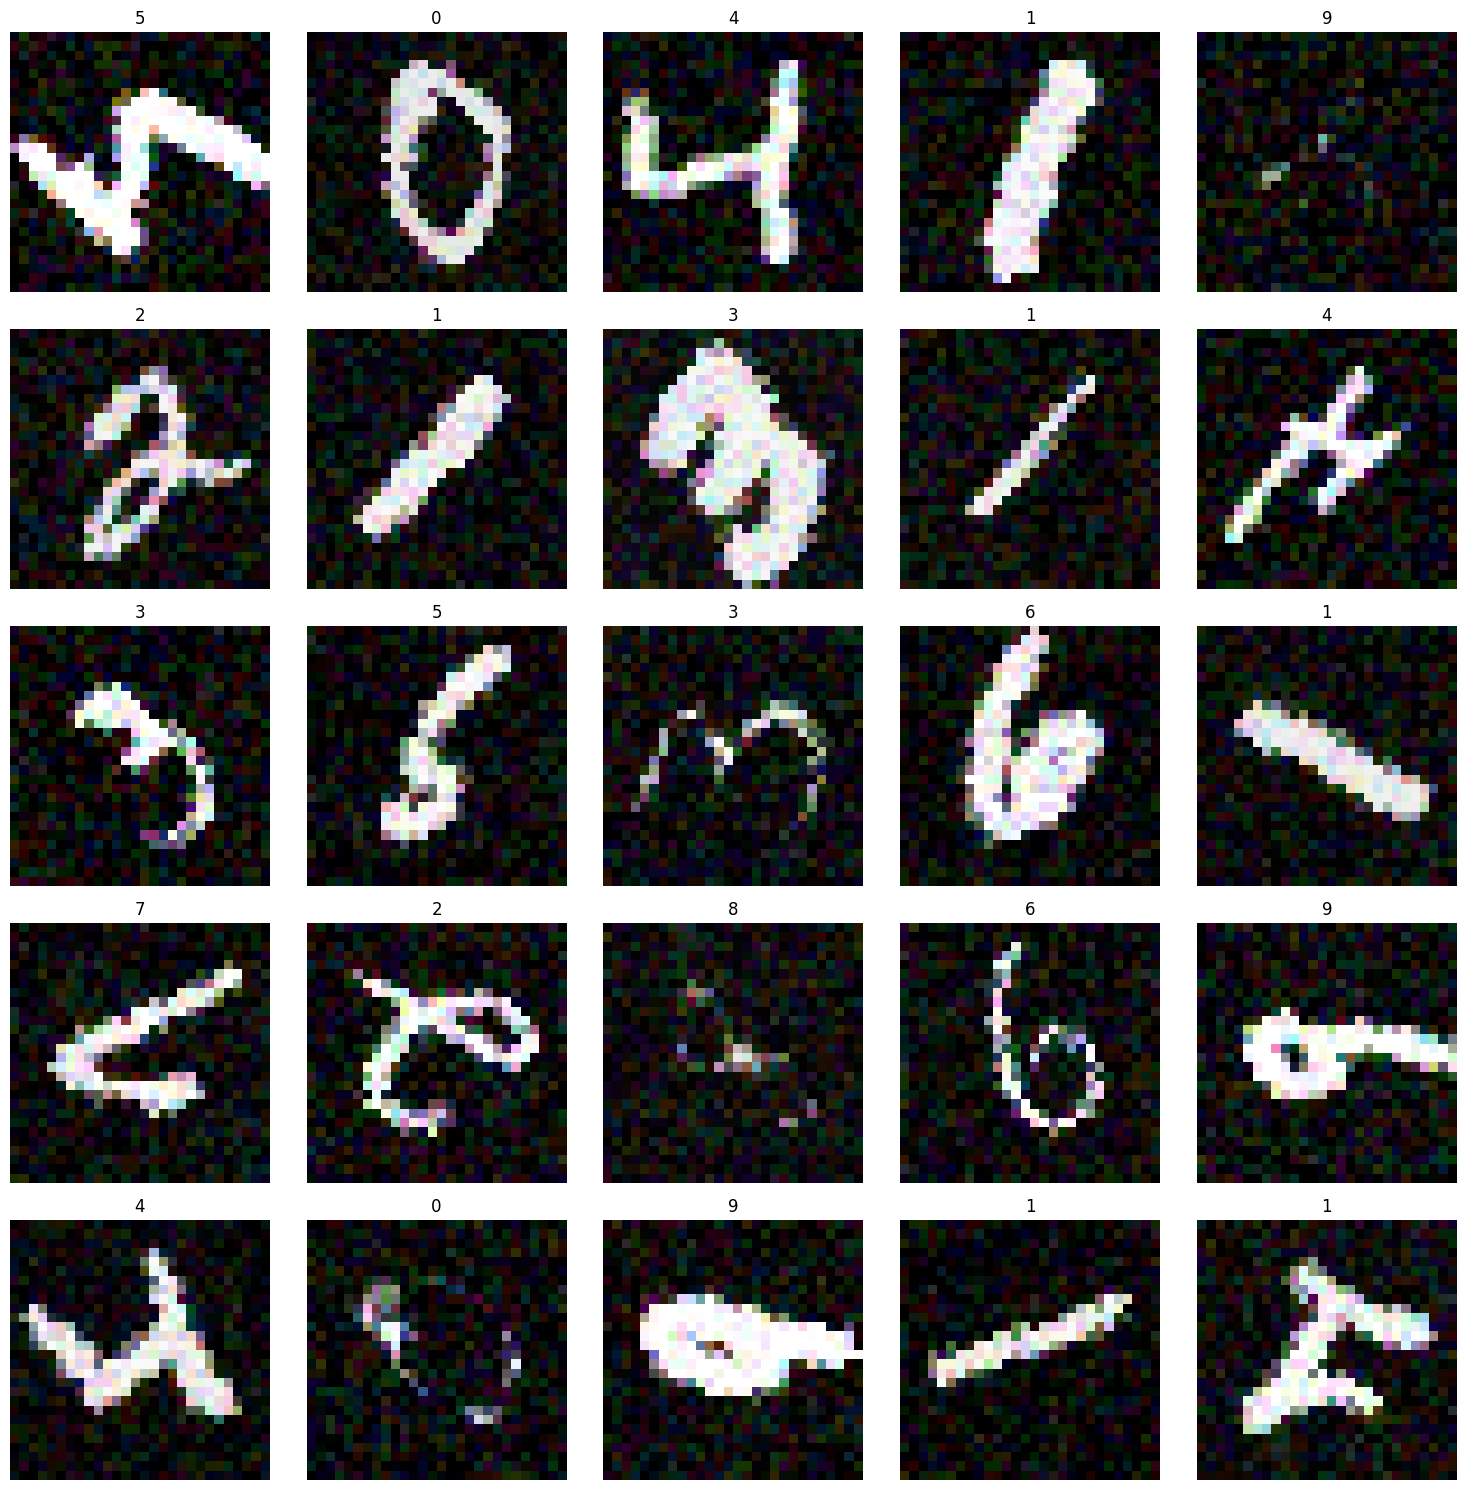

In [265]:
from torchvision.transforms import ToTensor, Compose
from torch import Tensor, tensor, eye

def get_img_tfms(training: bool, transform_train=transform_seq) -> Compose:
    """Return a composition of image transforms.

    Parameters
    ----------
    training : bool
        Are we training? If ``False``, we are validating.

    Returns
    -------
    Compose
        A composition of image transforms.

    """
    # Convert the image from being a 2D tensor to have 3 values for each pixel (RGB).
    # Since the three values are the same it remains the same grayscale image

    tfm_list = [ToTensor(), lambda x: x.repeat(3, 1, 1)]

    if training is True:
        # If training, transform the images
        return transform_train
    else:
        # If not training, just change to color image but leave unchanged
        return [ToTensor(), lambda x: x.repeat(3, 1, 1)]


def target_as_tensor(target_idx: int) -> Tensor:
    """Express the target as a ``torch.Tensor``.

    Parameters
    ----------
    target_idx : int
        The ground truth (i.e. the number shown in the image).

    Returns
    -------
    Tensor
        The target as a one-hot-encoded vector.

    """
    return eye(10)[target_idx]


train_set = MNIST(
    mnist_root,
    transform=get_img_tfms(training=True),
    target_transform=target_as_tensor,
    train=True,
)


valid_set = MNIST(
    mnist_root,
    transform=get_img_tfms(training=False),
    target_transform=target_as_tensor,
    train=False,
)

figure, axes = plt.subplots(5, 5, figsize=(15, 15))

for idx, axis in enumerate(axes.ravel()):
    image, target = train_set[idx]

    axis.imshow(image.permute(1, 2, 0), cmap="inferno")
    axis.set_title(int(target.argmax()))
    axis.set_axis_off()

plt.tight_layout()

### Task 3: ``Dataset`` $\to$ ``DataLoader``

As before, wrap the ``Dataset``s in ``DataLoader``s.

In [ ]:
from torch.utils.data import DataLoader

batch_size = 64

### Task 4: Choose a model architecture

Torchvision provides a collection of models, [here](https://pytorch.org/vision/stable/models.html).

Since we are all using laptops, many of which don't have CUDA-enabled GPUs, we will select a modest neural network than won't melt any of our hardware. Such a network, designed for mobile phones, is [``MOBILENET``](https://pytorch.org/vision/stable/models/mobilenetv3.html).

#### Task 4 (a): instantiate the small version of ``MOBILENET``, and print it out.

Note:
- Torchvision's models can optionally be endowed with pretrained weights (from corresponding models pretrain on the ImageNet dataset).
- We can (optionally) supply these weights.
  - Using weights from a model, trained on one problem, as an initial condition in another problem, is called transfer learning.
  - Why do you think this might be advantageous, even in disparate problems?
    - ...

In [ ]:
from torchvision.models import mobilenet_v3_small
from torchvision.models import MobileNet_V3_Small_Weights

model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)
print(model)

#### Task 4 (b): overloading the final layer

Uh oh, we've hit a problem.

- Look at the final linear layer.
  - How many output classes are there?
  - How many do we need?
- We need to "overload" the final layer to produce the correct number of output features for our problem. Fortunately this is easy.
- Uncomment the code below, choose the correct number of output features, and print the model again.

In [ ]:
from torch.nn import Linear

# model.classifier[3] = Linear(model.classifier[3].in_features, ???)

### Task 5: Set up the remaining PyTorch bits and bobs

- We need to choose a loss function appropriate for classification.
  - Can you remember what we chose previously?
- We need an optimiser, too.
  - Remember our friend, Adam?
- Instantiate the model and loss function.

In [ ]:
from torch.nn import BCELoss
from torch.optim import Adam

### Task 6: Set the device

We could have done this when we created the model, but it's fine to do it here.  
- If [CUDA](https://pytorch.org/docs/stable/cuda.html) (NVIDIA GPU) is available we will elect to run on that.
- Alternatively, if we are on Apple Silicon we can use the [MPS backend](https://developer.apple.com/metal/pytorch/) for GPU acceleration.
- If neither of these are available we will resort to using the (slower) CPU.

In [ ]:
import torch.cuda as cuda
import torch.backends.mps as mps

if cuda.is_available():
    DEVICE = "cuda"
elif mps.is_available():
    DEVICE = "mps"
else:
    DEVICE = "cpu"

print(DEVICE)

# Note: here the return/assignment to ``_`` is just to suppress the print.
# The model is moved onto the correct device in-place.
_ = model.to(DEVICE)

### Task 7: Writing our training and validation loops

As before, we need to write our training and validation loops.

- Complete the training loop
- Complete the validation loop

In [ ]:
from typing import Dict

from torch import no_grad
from torch.nn import Module


def train_one_epoch(
    model: Module,
    train_loader: DataLoader,
    optimiser: Adam,
    loss_func: BCELoss,
) -> Dict[str, float]:
    """Train the model for a single epoch.

    Parameters
    ----------
    model : Module
        A neural network.
    train_loader : DataLoader
        The ``DataLoader`` for the training set.
    optimiser : Adam
        The optimiser to update the model's parameters with.
    loss_func : BCELoss
        Binary-cross-entropy loss function.

    Returns
    -------
    Dict[str, float]
        A dictionary of metrics.

    """
    model.train()


@no_grad()
def validate_one_epoch(
    model: Module,
    valid_loader: DataLoader,
    loss_func: BCELoss,
) -> Dict[str, float]:
    """Train the model for a single epoch.

    Parameters
    ----------
    model : Module
        A neural network.
    valid_loader : DataLoader
        The ``DataLoader`` for the validation set.
    loss_func : BCELoss
        Binary-cross-entropy loss function.

    Returns
    -------
    Dict[str, float]
        A dictionary of metrics.

    """
    model.eval()

### Task 8: Training and extracting metrics

- Now we can train our model for a specified number of epochs.
  - During each epoch the model "sees" each training item once.
- Append the training and validation metrics to a list.
- Turn them into a ``pandas.DataFrame``
  - Note: You can turn a ``List[Dict[str, float]]``, say ``my_list`` into a ``DataFrame`` with ``DataFrame(my_list)``.

In [ ]:
epochs = 5

for _ in range(epochs):
    pass

### Task 9: Plotting metrics

 - Let plots the training and validation metrics together

In [ ]:
import matplotlib.pyplot as plt

# ...

### Task 10: Visualising some predictions

Let's pick some random validation items, predict on them, and visualise the results.

In [ ]:
valid_inds = [8, 16, 24, 32, 40]

# Stick the model on the cpu
_ = model.to("cpu")
_ = model.eval()

# figure, axes = plt.subplots(1, len(valid_inds), figsize=(2 * len(valid_inds), 2))

# for idx, axis in zip(valid_inds, axes.ravel()):
#     img_tensor, target = valid_set[idx]

#     with no_grad():
#         pred = model(img_tensor.unsqueeze(0)).softmax(dim=1).argmax(dim=1).item()

#     axis.imshow(img_tensor.permute(1, 2, 0))
#     axis.set_axis_off()
#     axis.set_title(f"pred: {pred}, act: {target.argmax()}")

##